In [1]:
# ============================================
# 1. Imports and Setup
# ============================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
from time import time

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, log_loss, f1_score, accuracy_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance

from xgboost import XGBClassifier

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [2]:
# ============================================
# 2. Load Data
# ============================================
df = pd.read_csv("balanced_tb_data.csv")
df_test = pd.read_csv("balanced_tb_data_clean.csv")


In [3]:
df_test.replace({"Yes": 1, "No": 0, "Not sure": 0, "Male": 1, "Female": 0}, inplace=True)
if "participant" in df_test.columns and "sound_prediction_score" in df_test.columns:
    df_test.drop(["participant", "sound_prediction_score"], axis=1, inplace=True)

print("Train shape:", df.shape)
print("Test shape :", df_test.shape)
print("\nTarget distribution:")
print(df["tb_status"].value_counts())


Train shape: (9800, 783)
Test shape : (9800, 783)

Target distribution:
tb_status
1    4900
0    4900
Name: count, dtype: int64


In [4]:
# ============================================
# 3. Add small label noise + noise features
# ============================================
np.random.seed(42)
noise_frac = 0.02
noise_idx = df.sample(frac=noise_frac, random_state=42).index
df.loc[noise_idx, "tb_status"] = 1 - df.loc[noise_idx, "tb_status"]

for i in range(10):
    df[f"noise_{i}"] = np.random.randn(len(df))
    df_test[f"noise_{i}"] = np.random.randn(len(df_test))

#print(f"Added label noise ({noise_frac*100:.1f}%) and 10 random noise features.")


In [5]:
# ============================================
# 4. Features + Split + Scaling
# ============================================
clinical_features = [c for c in df.columns if not c.startswith("feat_") and not c.startswith("noise_") and c != "tb_status"]
audio_features    = [c for c in df.columns if c.startswith("feat_")]
noise_features    = [c for c in df.columns if c.startswith("noise_")]
all_features      = audio_features + clinical_features + noise_features



In [6]:
X = df[all_features]
y = df["tb_status"]



In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled  = scaler.transform(df_test[all_features])


In [9]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("Train:", X_train.shape, "Valid:", X_valid.shape)

Train: (7840, 792) Valid: (1960, 792)


In [10]:
# ============================================
# 5. Logistic Regression
# ============================================
logreg = LogisticRegression(max_iter=1000, C=0.5, random_state=42)
cv_results = cross_validate(
    logreg, X_train_scaled, y_train, cv=cv,
    scoring=["accuracy", "f1", "roc_auc"], return_estimator=False, n_jobs=1
)

print("LogReg CV mean accuracy: {:.4f}, mean f1: {:.4f}, mean AUC: {:.4f}".format(
    cv_results["test_accuracy"].mean(),
    cv_results["test_f1"].mean(),
    cv_results["test_roc_auc"].mean()
))




LogReg CV mean accuracy: 0.9769, mean f1: 0.9769, mean AUC: 0.9791


In [11]:
logreg.fit(X_train_scaled, y_train)
y_valid_logreg = logreg.predict(X_valid_scaled)
y_valid_logreg_proba = logreg.predict_proba(X_valid_scaled)[:,1]

print("\nValidation Report (Logistic Regression)\n")
print(classification_report(y_valid, y_valid_logreg))



Validation Report (Logistic Regression)

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       978
           1       0.97      0.98      0.97       982

    accuracy                           0.97      1960
   macro avg       0.97      0.97      0.97      1960
weighted avg       0.97      0.97      0.97      1960



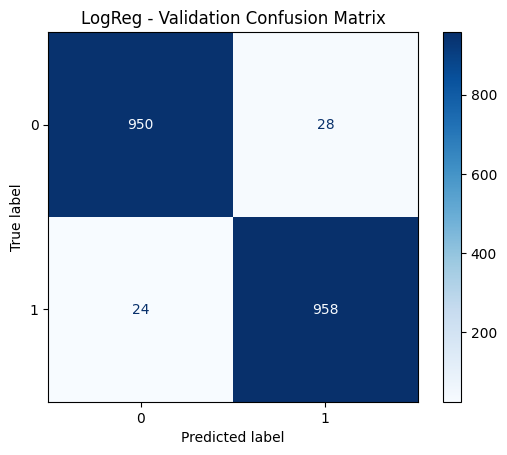

In [12]:
ConfusionMatrixDisplay(confusion_matrix(y_valid, y_valid_logreg)).plot(cmap="Blues")
plt.title("LogReg - Validation Confusion Matrix")
plt.show()



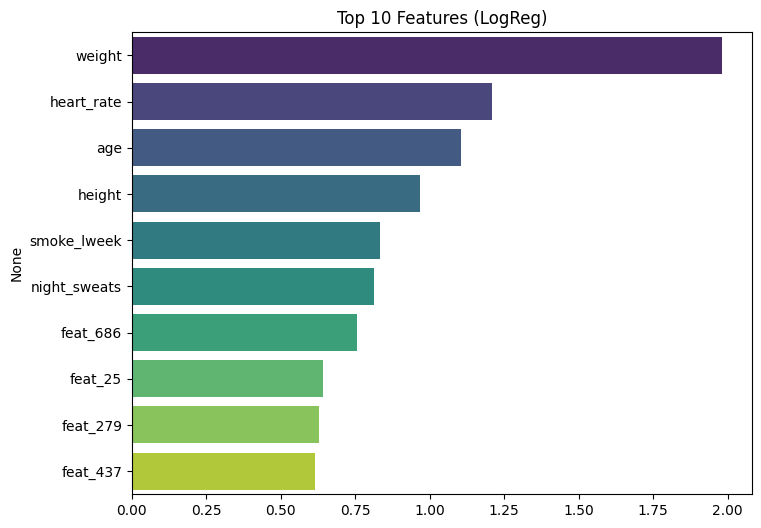

In [13]:
coeffs = pd.Series(logreg.coef_[0], index=all_features)
top10_logreg = coeffs.abs().sort_values(ascending=False).head(10)
plt.figure(figsize=(8,6))
sns.barplot(x=top10_logreg.values, y=top10_logreg.index, palette="viridis")
plt.title("Top 10 Features (LogReg)")
plt.show()

In [14]:
# building model with random forest

In [15]:
# ============================================
# 6. Random Forest
# ============================================
rf = RandomForestClassifier(n_estimators=100, max_depth=6, class_weight="balanced", random_state=42)
cv_results = cross_validate(
    rf, X_train_scaled, y_train, cv=cv,
    scoring=["accuracy","f1","roc_auc"], return_estimator=False, n_jobs=1
)

print("RandomForest CV mean accuracy: {:.4f}, mean f1: {:.4f}, mean AUC: {:.4f}".format(
    cv_results["test_accuracy"].mean(),
    cv_results["test_f1"].mean(),
    cv_results["test_roc_auc"].mean()
))



RandomForest CV mean accuracy: 0.9723, mean f1: 0.9726, mean AUC: 0.9796


In [16]:
rf.fit(X_train_scaled, y_train)
y_valid_rf = rf.predict(X_valid_scaled)
y_valid_rf_proba = rf.predict_proba(X_valid_scaled)[:,1]

print("\nValidation Report (Random Forest)\n")
print(classification_report(y_valid, y_valid_rf))


Validation Report (Random Forest)

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       978
           1       0.96      0.98      0.97       982

    accuracy                           0.97      1960
   macro avg       0.97      0.97      0.97      1960
weighted avg       0.97      0.97      0.97      1960



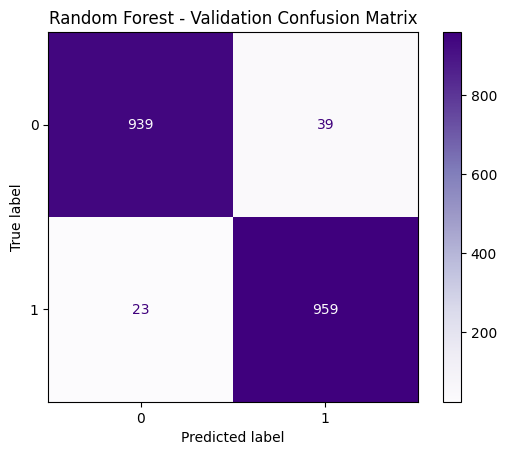

In [17]:
ConfusionMatrixDisplay(confusion_matrix(y_valid, y_valid_rf)).plot(cmap="Purples")
plt.title("Random Forest - Validation Confusion Matrix")
plt.show()

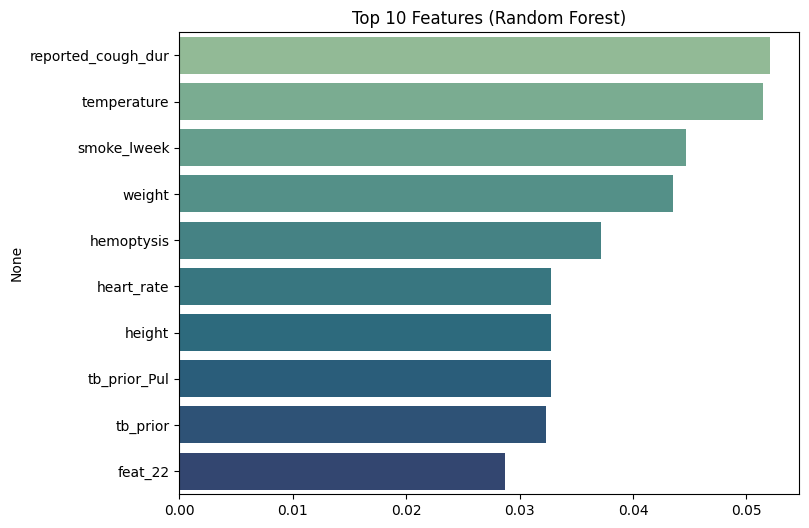

In [18]:
importances_rf = pd.Series(rf.feature_importances_, index=all_features).sort_values(ascending=False).head(10)
plt.figure(figsize=(8,6))
sns.barplot(x=importances_rf.values, y=importances_rf.index, palette="crest")
plt.title("Top 10 Features (Random Forest)")
plt.show()

In [19]:
# Building model with XGBOOST

In [20]:
# ============================================
# 7. XGBoost (tuned)
# ============================================
xgb_base = XGBClassifier(
    n_estimators=150, learning_rate=0.1, max_depth=4,
    subsample=0.8, colsample_bytree=0.8,
    eval_metric="logloss", use_label_encoder=False, random_state=42
)

param_dist = {
    "n_estimators": [100, 150, 200],
    "max_depth": [3,4,5],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}



In [21]:
rs = RandomizedSearchCV(
    estimator=xgb_base, param_distributions=param_dist,
    n_iter=5, scoring="f1", cv=3, n_jobs=1, random_state=42, verbose=0
)



In [22]:
rs.fit(X_train_scaled, y_train)
best_xgb = rs.best_estimator_



In [23]:
y_valid_xgb = best_xgb.predict(X_valid_scaled)
y_valid_xgb_proba = best_xgb.predict_proba(X_valid_scaled)[:,1]



In [24]:
print("\nValidation Report (XGBoost)\n")
print(classification_report(y_valid, y_valid_xgb))




Validation Report (XGBoost)

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       978
           1       0.97      0.98      0.98       982

    accuracy                           0.97      1960
   macro avg       0.98      0.97      0.97      1960
weighted avg       0.98      0.97      0.97      1960



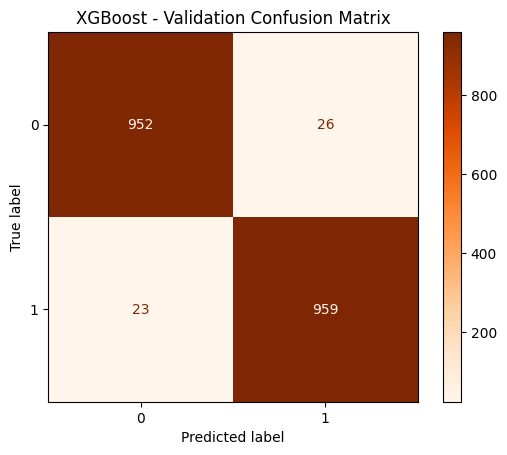

In [25]:
ConfusionMatrixDisplay(confusion_matrix(y_valid, y_valid_xgb)).plot(cmap="Oranges")
plt.title("XGBoost - Validation Confusion Matrix")
plt.show()



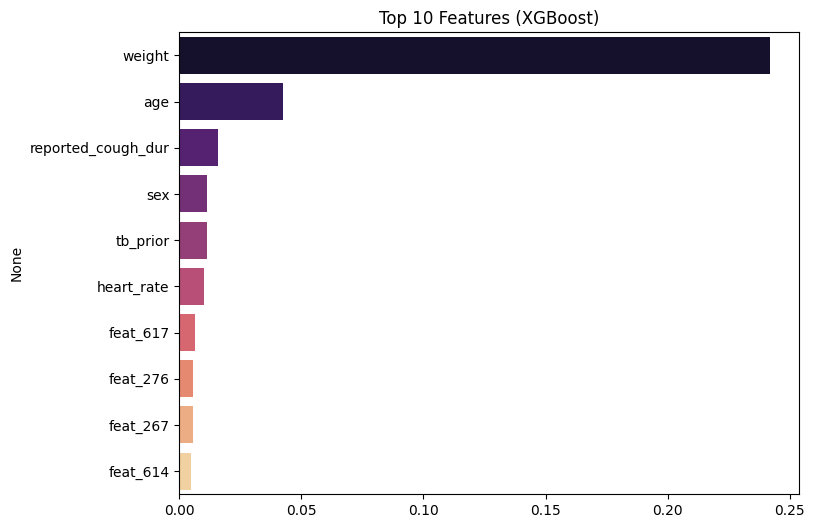

In [26]:
xgb_imp = pd.Series(best_xgb.feature_importances_, index=all_features).sort_values(ascending=False).head(10)
plt.figure(figsize=(8,6))
sns.barplot(x=xgb_imp.values, y=xgb_imp.index, palette="magma")
plt.title("Top 10 Features (XGBoost)")
plt.show()

In [27]:
#building model with MLP

In [28]:
# ============================================
# 8. MLP
# ============================================
mlp = MLPClassifier(hidden_layer_sizes=(64,32), alpha=0.001, max_iter=500, random_state=42)
mlp.fit(X_train_scaled, y_train)



MLPClassifier(alpha=0.001, hidden_layer_sizes=(64, 32), max_iter=500,
              random_state=42)

In [29]:
y_valid_mlp = mlp.predict(X_valid_scaled)
y_valid_mlp_proba = mlp.predict_proba(X_valid_scaled)[:,1]

print("\nValidation Report (MLP)\n")
print(classification_report(y_valid, y_valid_mlp))


Validation Report (MLP)

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       978
           1       0.97      0.96      0.97       982

    accuracy                           0.97      1960
   macro avg       0.97      0.97      0.97      1960
weighted avg       0.97      0.97      0.97      1960



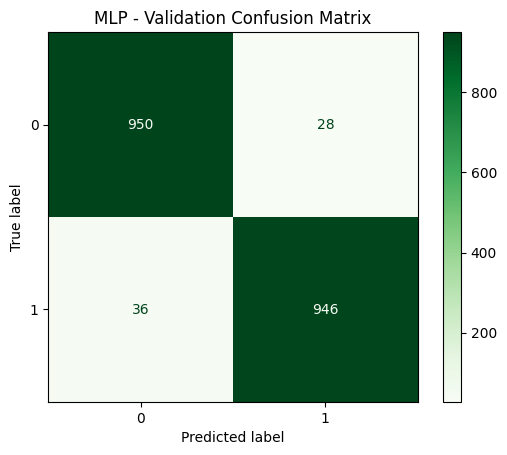

In [30]:
ConfusionMatrixDisplay(confusion_matrix(y_valid, y_valid_mlp)).plot(cmap="Greens")
plt.title("MLP - Validation Confusion Matrix")
plt.show()



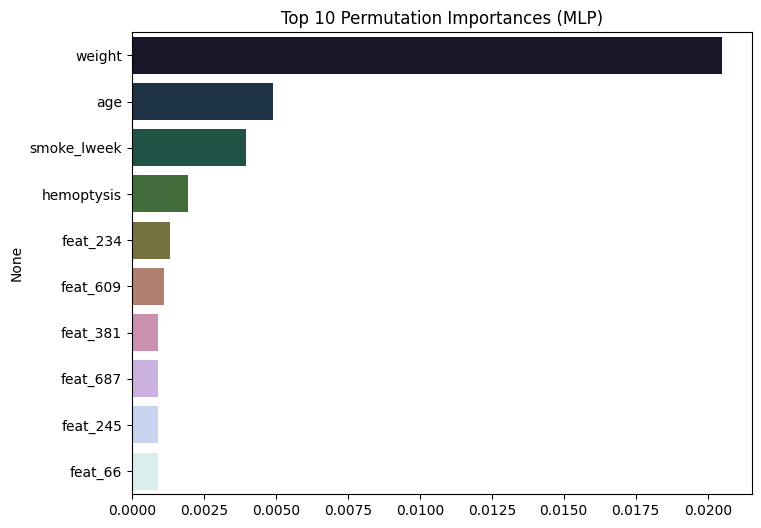

In [31]:
pi = permutation_importance(mlp, X_valid_scaled, y_valid, n_repeats=5, random_state=42, n_jobs=1)
pi_ser = pd.Series(pi.importances_mean, index=all_features).sort_values(ascending=False).head(10)
plt.figure(figsize=(8,6))
sns.barplot(x=pi_ser.values, y=pi_ser.index, palette="cubehelix")
plt.title("Top 10 Permutation Importances (MLP)")
plt.show()


In [32]:
# ============================================
# 9. Validation-set metrics & model selection
# ============================================
models = {
    "LogisticRegression": {"model": logreg, "y_pred": y_valid_logreg, "y_proba": y_valid_logreg_proba},
    "RandomForest": {"model": rf, "y_pred": y_valid_rf, "y_proba": y_valid_rf_proba},
    "XGBoost": {"model": best_xgb, "y_pred": y_valid_xgb, "y_proba": y_valid_xgb_proba},
    "MLP": {"model": mlp, "y_pred": y_valid_mlp, "y_proba": y_valid_mlp_proba}
}


In [33]:
selection_scores = {}
for name, info in models.items():
    y_pred = info["y_pred"]
    y_proba = info["y_proba"]
    f1 = f1_score(y_valid, y_pred, average="weighted")
    acc = accuracy_score(y_valid, y_pred)
    auc = roc_auc_score(y_valid, y_proba)
    ll  = log_loss(y_valid, y_proba)
    selection_scores[name] = {"f1":f1, "accuracy":acc, "auc":auc, "logloss":ll}
    print(f"{name} -> F1:{f1:.3f}, Acc:{acc:.3f}, AUC:{auc:.3f}, LogLoss:{ll:.3f}")


LogisticRegression -> F1:0.973, Acc:0.973, AUC:0.974, LogLoss:0.142
RandomForest -> F1:0.968, Acc:0.968, AUC:0.979, LogLoss:0.130
XGBoost -> F1:0.975, Acc:0.975, AUC:0.976, LogLoss:0.119
MLP -> F1:0.967, Acc:0.967, AUC:0.970, LogLoss:0.263


In [34]:
# saving the best model

In [35]:
# ============================================
# 10. Pick best model & save
# ============================================
weights = {"f1":0.4, "accuracy":0.4, "auc":0.3, "logloss":0.1}
final_scores = {
    m: weights["f1"]*sc["f1"] + weights["accuracy"]*sc["accuracy"] +
       weights["auc"]*sc["auc"] - weights["logloss"]*sc["logloss"]
    for m, sc in selection_scores.items()
}

best_model_name = max(final_scores, key=final_scores.get)
best_model_instance = models[best_model_name]["model"]

print("\nFinal weighted scores:")
print(final_scores)
print(f"\n Best model: {best_model_name}")




Final weighted scores:
{'LogisticRegression': np.float64(1.0566721914894586), 'RandomForest': np.float64(1.055297629694624), 'XGBoost': np.float64(1.0610063552284326), 'MLP': np.float64(1.038586740253273)}

 Best model: XGBoost


In [36]:
os.makedirs("trained_models", exist_ok=True)
joblib.dump(best_model_instance, f"trained_models/{best_model_name}_best_model.joblib")
joblib.dump(scaler, "trained_models/scaler.joblib")
joblib.dump({"selection_scores": selection_scores, "final_scores": final_scores, "weights":weights},
            f"trained_models/{best_model_name}_metadata.joblib")


['trained_models/XGBoost_metadata.joblib']